In [96]:
import numpy as np
from numpy import unique
from numpy import where
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas import DataFrame
from sklearn.cluster import KMeans
from sklearn import datasets
import sklearn.cluster as skl_cluster
import sklearn.datasets.samples_generator as skl_smpl
from matplotlib import pyplot as plt

In [102]:
class KerKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, centroids=3, loop=50, cap=1e-3, random_state=None,
                 kernel="laplacian", gamma=0.0078, degree=3, df=1,
                 vals=None, backG=0):
        self.centroids = centroids
        self.loop = loop
        self.cap = cap
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.df = df
        self.vals = vals
        self.backG = backG
 
    def KernelComputation(self, X, Y=None):
        if callable(self.kernel):
            kernel_values = self.vals or {}
        else:
            kernel_values = {"gamma": self.gamma,
                      "degree": self.degree,
                      "df": self.df}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **kernel_values)

    def fit(self, X, y=None, wt=None):
        total = X.shape[0]
        
        K = self.KernelComputation(X)
        WithinS = wt if wt else np.ones(total)
        self.wt = WithinS
        
        self_rand = check_random_state(self.random_state)
        self.labels_ = self_rand.randint(self.centroids, size=total)
        dist = np.zeros((total, self.centroids))
        self.Distance_matrix_within = np.zeros(self.centroids)
        for it in range(self.loop):
            dist.fill(0)
            self.EqdDistance(K, dist, self.Distance_matrix_within,check=True)
            predicts1 = self.labels_
            self.labels_ = dist.argmin(axis=1)           
            pq = np.sum((self.labels_ - predicts1) == 0)
            if 1 - float(pq) / total < self.cap:
                if self.backG:
                    print ("Done", it + 1)
                break

        self.X_fit_ = X
        return self

    def EqdDistance(self, K, dist, within_distances, check):
        WithinS = self.wt
        for j in range(self.centroids):
            fk = self.labels_== j
            if np.sum(fk) == 0:
                raise ValueError("Data not found in cluster")
            A = WithinS[fk].sum()
            Asquare = A * A
            if check:
                Ksquare = K[fk][:, fk]  
                dist_j = np.sum(np.outer(WithinS[fk], WithinS[fk]) * Ksquare / Asquare)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(WithinS[fk] * K[:, fk], axis=1) / A
    @property
    def KernelPair(self):
        return self.kernel == "precomputed"

    def predict(self, X):
        A = self.KernelComputation(X, self.X_fit_)
        total = X.shape[0]
        XX = np.zeros((total, self.centroids))
        self.EqdDistance(A, XX, self.Distance_matrix_within,
                           check=False)
        return XX.argmin(axis=1)

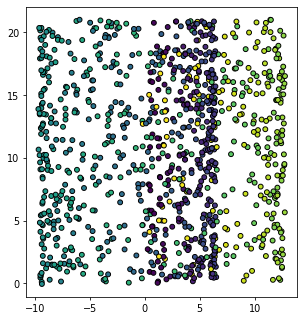

In [103]:
if __name__ == '__main__':
    from sklearn.datasets import make_s_curve
    from sklearn.datasets import make_swiss_roll
    X_data, y = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)
    plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y, s=25, edgecolor='k')

Text(0.5, 1.0, 'K means clustering on S-curve Data')

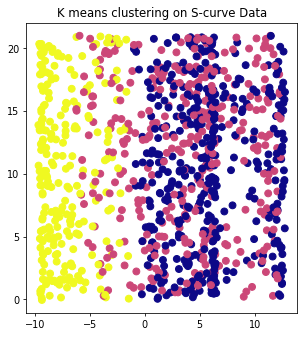

In [104]:
#Standard K means 
Kmean = skl_cluster.KMeans(n_clusters=3)
Kmean.fit(X_data)
clusters_scurve = Kmean.predict(X_data)

#plotting After K means Data 
plt.scatter(X_data[:, 0], X_data[:, 1], c=clusters_scurve, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':100})
plt.title("K means clustering on S-curve Data")

In [105]:
#Kernalized K means
km = KerKMeans(centroids=3, loop=100, random_state=0, backG=1)
print (km.fit_predict(X_data)[:10])
print (km.predict(X_data[:10]))
yhat_wine=km.predict(X_data)

Done 14
[0 0 2 1 2 2 2 0 1 2]
[0 0 2 1 2 2 2 0 1 2]


Text(0.5, 1.0, 'Kernel K-means clustering on Wine Data')

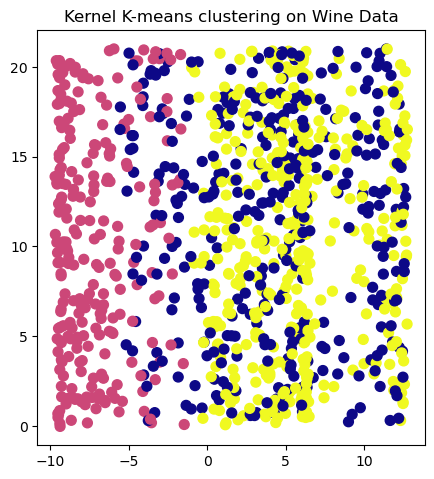

In [106]:
plt.scatter(X_data[:, 0], X_data[:, 1], c=yhat_wine, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':70})
plt.title("Kernel K-means clustering on Wine Data")